In [4]:
from nutils import*
from nutils.pointsseq import PointsSequence
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors, collections, cm
import os
import meshio
import vtk
from vtk.util import numpy_support

In [5]:
def GetLumenMesh(fname):
    reader = vtk.vtkXMLUnstructuredGridReader()
    reader.SetFileName(fname)
    reader.Update()
    return reader.GetOutput()

def GetMeshPoints(mesh):
    pts = mesh.GetPoints().GetData()
    pts_array = numpy_support.vtk_to_numpy(pts)
    return pts_array

def GetMeshCells(mesh):
    cells = mesh.GetCells().GetData()
    cells_array = numpy_support.vtk_to_numpy(cells)
    return cells_array
    
def GetMeshData(mesh, data_name):
    data = mesh.GetPointData().GetArray(data_name)
    data_array = numpy_support.vtk_to_numpy(data)
    return data_array

def BuildPlane(origin, normal):
    plane = vtk.vtkPlane()
    plane.SetOrigin(origin)
    plane.SetNormal(normal)
    return plane

def SliceMesh(mesh, plane):
    cutter = vtk.vtkCutter()
    cutter.SetCutFunction(plane)
    cutter.SetInputData(mesh)
    cutter.Update()
    return cutter.GetOutput(0)

def SqrDistance(ptA, ptB):
    return (ptA[0] - ptB[0])**2 + (ptA[1] - ptB[1])**2 + (ptA[2] - ptB[2])**2

def FilterPointsByDistance(mesh, plane, Rmax):
    npts = mesh.GetNumberOfPoints()
    pts_filtered = []
    tractions_filtered = []
    filter_map = [-1] * npts
    k = 0
    for i in range(npts):
        pt = mesh.GetPoint(i)
        sqrdist = SqrDistance(pt, plane.GetOrigin())
        if(sqrdist < Rmax**2):
            traction = mesh.GetPointData().GetArray("Traction").GetValue(i)
            filter_map[i] = k
            k += 1
            pts_filtered.append(pt)
            tractions_filtered.append(traction)
    return np.array(pts_filtered), filter_map

def FilterArray(mesh, data_name, filter_map):
    array = GetMeshData(mesh, data_name)
    n = len(array)
    filtered_array = []
    for i in range(n):
        if filter_map[i] != -1:
            filtered_array.append(array[filter_map[i]])
    return np.array(filtered_array)

def GetFilteredTopology(mesh, filter_map):
    ncells = mesh.GetNumberOfCells()
    connectivity = []
    for i in range(ncells):
        cell = mesh.GetCell(i)
        ids = cell.GetPointIds()
        idA = ids.GetId(0)
        idB = ids.GetId(1)
        if(filter_map[idA] != -1 and filter_map[idB] != -1):
            connectivity.append([filter_map[idA], filter_map[idB]])
    return np.array(connectivity)

def SortPointsByAngle(pts_array):
    pts = pts_array.copy()
    angles = np.zeros([len(pts)])
    u = pts[0]
    u /= np.linalg.norm(u)
    u = np.array([u[0], u[1], 0])
    for i in range(len(pts)):
        v = pts[i]
        v /= np.linalg.norm(v)
        v = np.array([v[0], v[1], 0])
        s = np.sign( CrossProduct(u,v)[2] )
        angles[i] = s * np.arccos(np.clip(v.dot(u),-1,1))
        if s < 0:
            angles[i] += 2 * np.pi
    inds = angles.argsort()
    return inds

def BuildConnectivityArray(npts):
    connectivity = np.zeros([npts,2], dtype=int)
    for i in range(npts):
        connectivity[i] = [i, (i+1) % npts]
    return connectivity

def CrossProduct(u,v):
    wx = (u[1]*v[2]-u[2]*v[1])
    wy = (u[0]*v[2]-u[2]*v[0])
    wz = (u[0]*v[1]-u[1]*v[0])
    return np.array([wx,wy,wz])

def DotProduct(u,v):
    d = 0.0
    for i,j in zip(u,v):
        d += i*j
    return d

def Distance(ptA, ptB):
    return np.sqrt(SqrDistance(ptA,ptB))

def GetTransformationMatrix(plane):
    normal = plane.GetNormal()
    if(normal[0] != 0):
        xaxis = np.array([-(normal[1]+normal[2])/normal[0], 1, 1])
        yaxis = CrossProduct(normal, xaxis)
    elif(normal[1] != 0):
        xaxis = np.array([1, -(normal[0]+normal[2])/normal[1], 1])
        yaxis = CrossProduct(normal, xaxis)
    elif(normal[2] != 0):
        xaxis = np.array([1, 1, -(normal[0]+normal[1])/normal[2]])
        yaxis = CrossProduct(normal, xaxis)
    xaxis /= np.linalg.norm(xaxis)
    yaxis /= np.linalg.norm(yaxis)
    return [xaxis, yaxis]

def TransformVectors(vectors, M):
    transformed_vectors = np.ndarray([vectors.shape[0],vectors.shape[1]-1])
    for i in range(len(vectors)):
        transformed_vectors[i] = [M[0].dot(vectors[i]), M[1].dot(vectors[i])]
    return transformed_vectors
    
def TranslatePoints(pts, plane):
    pts_translated = np.zeros(pts.shape)
    for i in range(len(pts)):
        pts_translated[i] = pts[i] - plane.GetOrigin()
    return pts_translated

def BuildNutilsMesh(pts, connectivity):
    connectivity_sorted = np.sort(connectivity)
    return  mesh.simplex( connectivity_sorted, connectivity_sorted, pts, {}, {}, {} )


def locatesample(fromsample, fromgeom, totopo, togeom, tol, dim=2, **kwargs):
    '''Clone ``fromsample`` onto unrelated topology ``totopo``

    Create a sample ``tosample`` of ``totopo`` such that ``fromgeom`` and
    ``togeom`` are equal on the respective samples and such that integrals are
    equal.

    Parameters
    ----------
    fromsample: :class:`nutils.sample.Sample`
      The sample to be located in ``totopo``.
    fromgeom: :class:`nutils.function.Array`
      The geometry evaluable on ``fromsample``.
    totopo: :class:`nutils.topology.Topology`
      The topology to create ``tosample`` on.
    togeom: :class:`nutils.function.Array`
      The geometry evaluable on ``totopo``.
    **kwargs:
      All keyword arguments are passed to
      :meth:`nutils.topology.Topology.locate`.

    Returns
    -------
    tosample: :class:`nutils.sample.Sample`
      The sample of ``totopo``.

    '''

    tosample = totopo.locate(togeom, fromsample.eval(fromgeom), tol=tol, **kwargs)

    # Copy the weights from `fromsample` and account for the change in local
    # coordinates via the common geometry.
    weights = fromsample.eval(function.J(fromgeom)) / tosample.eval(function.J(togeom))
    for p, i in zip(fromsample.points, fromsample.index):
        weights[i] = p.weights
    weightedpoints = tuple(points.CoordsWeightsPoints(p.coords, weights[i]) for p, i in zip(tosample.points, tosample.index))
    weightedpoints = PointsSequence.from_iter(weightedpoints, dim)
    return sample.Sample.new(tosample.transforms, weightedpoints, tosample.index)

def PlotMesh(topo, geom, f, n=5):
    sample2d = topo.sample('bezier', n)
    xvals = sample2d.eval(geom)
    fvals = sample2d.eval(f)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1,1,1)
    ax.set_title("Mesh")
    ax.tripcolor(xvals[:,0], xvals[:,1], sample2d.tri, fvals, shading='gouraud', rasterized=True)
    sample_verts = topo.sample('bezier',2)
    verts = sample_verts.eval(geom)
    ax.add_collection(collections.LineCollection(verts[sample_verts.hull], colors='w', linewidth=0.5, alpha=1))
    return ax

def RefineBySDF(topo, sdf, nrefine, dim=2):
    refined_topo = topo
    for n in range(nrefine):
        elems_to_refine = []
        k = 0
        bez = refined_topo.sample('bezier',2)
        sd = bez.eval(sdf)
        sd = sd.reshape( [len(sd)//2**dim, 2**dim] )
        for i in range(len(sd)):
            if np.any(np.not_equal(np.sign(sd[i,:]),np.sign(sd[i,0]))) or np.any(np.equal(np.sign(sd[i,:]),0)):
                elems_to_refine.append(k)
            k = k + 1
        if len(elems_to_refine) != 0:
            refined_topo = refined_topo.refined_by(refined_topo.transforms[np.array(elems_to_refine)])
    return refined_topo

def Plot(figs, plots, xlabels, ylabels, results, exact, legend, COLOR_BY_CASE = True):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for fig in figs:
        cit = iter(colors)
        figure = plt.figure(figsize=(10,10))
        ax = figure.add_subplot(1,1,1)
        ax.set_xlabel(xlabels[fig])
        ax.set_ylabel(ylabels[fig])
        ax.set_title(figs[fig])
        label_exact = []
        for plot in plots[fig]:
            if plot in exact:
                label_exact = ["exact"]
                ax.plot(exact["r"], exact[plot], 'k--')
            for col, case in zip(colors,results):
                if COLOR_BY_CASE == False:
                    col = next(cit)
                ax.plot(results[case]["r"], results[case][plot], color=col)
        ax.legend(np.concatenate([label_exact,[case for case in cases]]))
        plt.show()

def Resize(x,n):
    if np.isscalar(x):
        x = [x for i in range(n)]
    if len(x) != n:
        x = [x[0] for i in range(n)]
    return x

def RunImmersedArtery(ri, ro, L, E_b, nu_b, E_a, nu_a, E_h, nu_h, pi, Nx, Ny, Nu, p, q, qu, nref, nqref, vals1d, vals2d, PLOT_LINES = False, delta=0.0, PROJECT_MAT_PROPS=False, p_proj=3,USE_DIRICHLET=False):
    # initialize results
    results = {}
    ncases = len(cases)
    
    # resize input
    ri = Resize(ri,ncases)
    ro = Resize(ro,ncases)
    L = Resize(L,ncases)
    nu_b = Resize(nu_b,ncases)
    E_b = Resize(E_b,ncases)
    nu_a = Resize(nu_a,ncases)
    E_a = Resize(E_a,ncases)
    nu_h = Resize(nu_h,ncases)
    E_h = Resize(E_h,ncases)
    pi = Resize(pi,ncases)
    Nx = Resize(Nx,ncases)
    Ny = Resize(Ny,ncases)
    Nu = Resize(Nu,ncases)
    p = Resize(p,ncases)
    q = Resize(q,ncases)
    qu = Resize(qu,ncases)
    nref = Resize(nref,ncases)
    nqref = Resize(nqref,ncases)
    
    for i in range(ncases):
        results[cases[i]] = ImmersedArtery(ri[i], ro[i], L[i], E_b[i], nu_b[i], E_a[i], nu_a[i], E_h[i], nu_h[i], pi[i], Nx[i], Ny[i], Nu[i], p[i], q[i], qu[i], nref[i], nqref[i], vals1d, vals2d, PLOT_LINES=PLOT_LINES, delta=delta, PROJECT_MAT_PROPS=PROJECT_MAT_PROPS, p_proj=p_proj,USE_DIRICHLET=USE_DIRICHLET)
        print( "Finished case : " + str(cases[i]) )
    
    return results

In [6]:
# Read lumen Mesh Data
fname = "data\\flow_sim.vtu"
lumen_mesh = GetLumenMesh(fname)

In [7]:
# Define Sampling Plane
sampling_plane_origin = (39.35025102748692, -182.88678578819045, 635.1077093084257)
sampling_plane_normal = (0.16669412398742134, -0.9856447804529322, 0.026784991953651572)
sampling_plane = BuildPlane(sampling_plane_origin, sampling_plane_normal)

In [10]:
print(sampling_plane.GetOrigin())

(39.35025102748692, -182.88678578819045, 635.1077093084257)


In [8]:
# Slice Mesh
lumen_mesh_slice = SliceMesh(lumen_mesh, sampling_plane)

In [8]:
# Create Filtered Mesh
R = 4
pts_filtered, fmap = FilterPointsByDistance(lumen_mesh_slice, sampling_plane, R)
tractions_filtered = FilterArray(lumen_mesh_slice, "Traction", fmap)

In [9]:
# transform
M = GetTransformationMatrix(sampling_plane)
pts_translated = TranslatePoints(pts_filtered, sampling_plane)
pts_transformed = TransformVectors(pts_translated, M)
tractions_transformed = TransformVectors(tractions_filtered, M)

In [10]:
# sort
inds = SortPointsByAngle(pts_transformed)
sorted_pts = pts_transformed[inds]
sorted_tractions = tractions_transformed[inds]

In [11]:
# build connectivity
connectivity = BuildConnectivityArray(len(sorted_pts))

In [10]:
# build nutils mesh
gamma = function.Namespace()
gamma_topo, gamma.x = BuildNutilsMesh(sorted_pts, connectivity)

In [11]:
# build traction function
gamma.linbasis = gamma_topo.basis('spline',degree=1)
gamma.tx = gamma.linbasis.dot(sorted_tractions[:,0])
gamma.ty = gamma.linbasis.dot(sorted_tractions[:,1])
gamma.traction_i = '<tx, ty>_i'

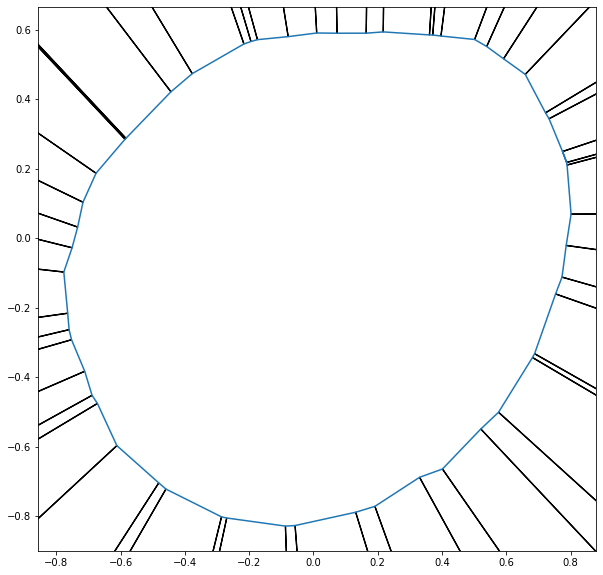

In [12]:
# plot mesh
sample = gamma_topo.sample('bezier',2)
verts = sample.eval(gamma.x)
tvals = sample.eval(gamma.traction)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.plot(verts[:,0],verts[:,1])
for i in range(len(tvals)):
    v = tvals[i]
    a = verts[i]
    ax.arrow(a[0], a[1], v[0], v[1])

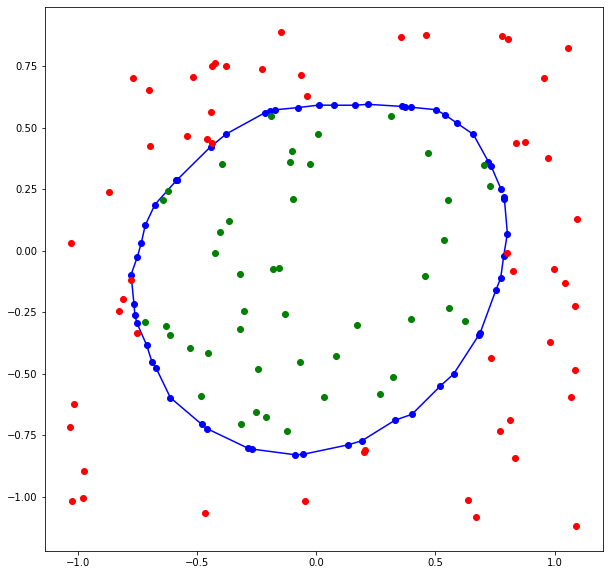

In [13]:
def IsInsidePolygon(verts, pt):
    nIntersections = 0
    p1 = verts[0]
    for i in range(1,len(verts)+1):
        p2 = verts[i % len(verts)]
        if pt[1] > min([p1[1],p2[1]]):
            if pt[1] <= max([p1[1],p2[1]]):
                if pt[0] <= max([p1[0],p2[0]]):
                    if p1[1] != p2[1]:
                        xint = (pt[1] - p1[1]) * (p2[0] - p1[0]) / (p2[1] - p1[1]) + p1[0]
                        if p1[0] == p2[0] or pt[0] <= xint:
                            nIntersections+=1
        p1 = p2
    if nIntersections % 2 == 0:
        return False
    else:
        return True

def Remap(val, a1, b1, a2, b2):
    return a2 + (val - a1) / (b1 - a1) * (b2 - a2)


N = 100
debug=False
h = 0.3

ax = min(sorted_pts[:,0]) - h
bx = max(sorted_pts[:,0]) + h
ay = min(sorted_pts[:,1]) - h
by = max(sorted_pts[:,1]) + h

fig = plt.figure(figsize=(10,10))
axes = fig.add_subplot(1,1,1)
axes.plot(sorted_pts[:,0], sorted_pts[:,1], '-bo')

for i in range(N):
    r1 = np.random.rand()
    r2 = np.random.rand()
    pt = [Remap(r1, 0, 1, ax, bx), Remap(r2, 0, 1, ay, by)]
    if IsInsidePolygon(sorted_pts, pt):
        axes.plot(pt[0],pt[1], 'go')
    else:
        axes.plot(pt[0],pt[1], 'ro')



In [ ]:
# http://www.eecs.umich.edu/courses/eecs380/HANDOUTS/PROJ2/InsidePoly.html#:~:text=To%20determine%20the%20status%20of,point%20is%20outside%20the%20polygon.

In [10]:
class PolygonInteriorIndicator(function.Pointwise):

    @staticmethod
    def evalf(x,y, val_in, val_out):
        shape = x.shape
        if shape == ():
            return x
        else:
            vals = np.zeros(shape)
            for j in range(shape[0]):
                pt = [x[j] , y[j]]
                nIntersections = 0
                p1 = sorted_pts[0]
                for i in range(1,len(sorted_pts)+1):
                    p2 = sorted_pts[i % len(sorted_pts)]
                    if pt[1] > min([p1[1],p2[1]]):
                        if pt[1] <= max([p1[1],p2[1]]):
                            if pt[0] <= max([p1[0],p2[0]]):
                                if p1[1] != p2[1]:
                                    xint = (pt[1] - p1[1]) * (p2[0] - p1[0]) / (p2[1] - p1[1]) + p1[0]
                                    if p1[0] == p2[0] or pt[0] <= xint:
                                        nIntersections+=1
                    p1 = p2
                if nIntersections % 2 == 0:
                    vals[j] = val_out
                else:
                    vals[j] = val_in
            return vals 
                    
    def _derivative(self, var, seen):
        return np.zeros(self.shape + var.shape)


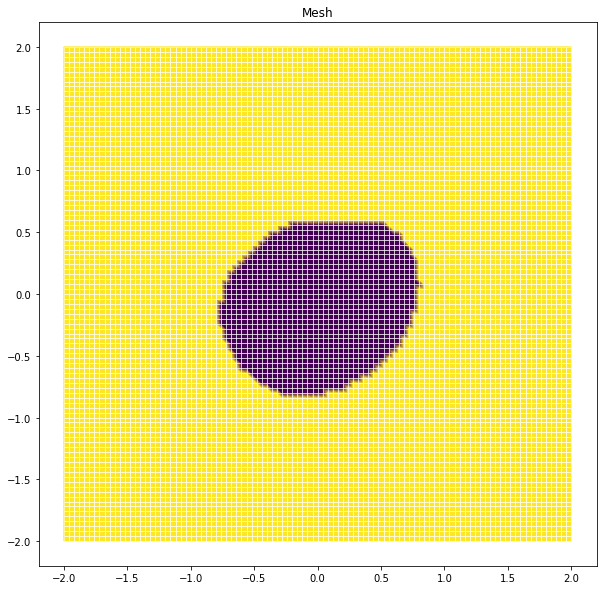

In [21]:
N = 100
val_in = 10
val_out = 5
x = np.linspace(-2,2,N+1)
ns = function.Namespace()
topo, ns.x = mesh.rectilinear([x,x])
ns.sd = PolygonInteriorIndicator(ns.x[0], ns.x[1], val_in, val_out)
PlotMesh(topo, ns.x, ns.sd, n=2)

In [15]:
def ReadMetaImage(fname):
    rd = vtk.vtkMetaImageReader()
    rd.SetFileName(fname)
    rd.Update()
    img = rd.GetOutput()
    return img

def GetPolyDataConnectivity(polydata):
    cells = polydata.GetPolys()
    conn = numpy_support.vtk_to_numpy( cells.GetConnectivityArray() )
    return conn

def GetImageOrigin(image):
    return np.array(image.GetOrigin())

def GetImageSpacing(image):
    return np.array(image.GetSpacing())

def GetImageShape(image):
    return np.array(image.GetDimensions())

def PolygonCentroid(pts):
    avg = pts[0].copy()
    for i in range(1,len(pts)):
        avg += pts[i]
    return avg / len(pts)

def EffectivePolygonDiameter(pts):
    d = 0.0
    A = pts[0]
    for i in range(1,len(pts)+1):
        B = pts[i % len(pts)]
        d += np.linalg.norm(B-A)
        A = B
    return d / np.pi
    

def ImmersedArtery(E_b, nu_b, E_a, nu_a, Nx, Ny, Lf, p, q, qu, nref, nqref, vals1d, vals2d, theta=np.pi/4, res1d = 200, res2d = 3, p_conv = 1, delta=0.0):

    # Read lumen Mesh Data
    fname = "data\\flow_sim.vtu"
    lumen_mesh = GetLumenMesh(fname)
    
    # Read in Autoplaque Image Data
    autoplaque_image = ReadMetaImage("data/autoplaque.mha")
    autoplaque_image_labels = GetMeshData(autoplaque_image, "MetaImage")
    autoplaque_image_origin = GetImageOrigin(autoplaque_image)
    autoplaque_image_spacing = GetImageSpacing(autoplaque_image)
    autoplaque_image_shape = GetImageShape(autoplaque_image)
    
    # Read in Artery Outer Wall SDF Image Data
    wall_sdf_image = ReadMetaImage("data/outer_wall.mha")
    wall_sdf_image_vals = GetMeshData(wall_sdf_image, "MetaImage")
    wall_sdf_image_origin = GetImageOrigin(wall_sdf_image)
    wall_sdf_image_spacing = GetImageSpacing(wall_sdf_image)
    wall_sdf_image_shape = GetImageShape(wall_sdf_image)

    # Define Sampling Plane
    sampling_plane_origin = (39.35025102748692, -182.88678578819045, 635.1077093084257)
    sampling_plane_normal = (0.16669412398742134, -0.9856447804529322, 0.026784991953651572)
    sampling_plane = BuildPlane(sampling_plane_origin, sampling_plane_normal)
    
    # Slice Mesh
    lumen_mesh_slice = SliceMesh(lumen_mesh, sampling_plane)
    
    # Create Filtered Mesh
    filter_radius = 4
    pts_filtered, fmap = FilterPointsByDistance(lumen_mesh_slice, sampling_plane, filter_radius)
    tractions_filtered = FilterArray(lumen_mesh_slice, "Traction", fmap)
    
    # transform data
    M = GetTransformationMatrix(sampling_plane)
    pts_translated = TranslatePoints(pts_filtered, sampling_plane)
    pts_transformed = TransformVectors(pts_translated, M)
    tractions_transformed = TransformVectors(tractions_filtered, M)
    
    # sort data
    inds = SortPointsByAngle(pts_transformed)
    sorted_pts = pts_transformed[inds]
    sorted_tractions = tractions_transformed[inds]
    
    # build lumen slice connectivity
    connectivity = BuildConnectivityArray(len(sorted_pts))
    
    # build immersed boundary mesh
    gamma = function.Namespace()
    gamma_topo, gamma.x = BuildNutilsMesh(sorted_pts, connectivity)
    
    # build traction function
    gamma.linbasis = gamma_topo.basis('spline',degree=1)
    gamma.tx = gamma.linbasis.dot(sorted_tractions[:,0])
    gamma.ty = gamma.linbasis.dot(sorted_tractions[:,1])
    gamma.traction_i = '<tx, ty>_i'
    
    # background mesh
    omega = function.Namespace()
    centroid = PolygonCentroid(sorted_pts)
    radius = EffectivePolygonDiameter(sorted_pts)
    xmin = centroid[0] - Lf * radius
    xmax = centroid[0] + Lf * radius
    ymin = centroid[1] - Lf * radius
    ymax = centroid[1] + Lf * radius
    x = np.linspace(xmin, xmax, Nx+1)
    y = np.linspace(ymin, ymax, Ny+1)
    omega_topo, omega.x = mesh.rectilinear([x,y])
    
    # Define Interior Function
    class PolygonInteriorIndicator(function.Pointwise):
        
        @staticmethod
        def evalf(x,y, val_in, val_out):
            shape = x.shape
            if shape == ():
                return x
            else:
                vals = np.zeros(shape)
                for j in range(shape[0]):
                    pt = [x[j] , y[j]]
                    nIntersections = 0
                    p1 = sorted_pts[0]
                    for i in range(1,len(sorted_pts)+1):
                        p2 = sorted_pts[i % len(sorted_pts)]
                        if pt[1] > min([p1[1],p2[1]]):
                            if pt[1] <= max([p1[1],p2[1]]):
                                if pt[0] <= max([p1[0],p2[0]]):
                                    if p1[1] != p2[1]:
                                        xint = (pt[1] - p1[1]) * (p2[0] - p1[0]) / (p2[1] - p1[1]) + p1[0]
                                        if p1[0] == p2[0] or pt[0] <= xint:
                                            nIntersections+=1
                        p1 = p2
                    if nIntersections % 2 == 0:
                        vals[j] = val_out
                    else:
                        vals[j] = val_in
                return vals 
        
        def _derivative(self, var, seen):
            return np.zeros(self.shape + var.shape)

        
    # Polygon Closest Point
    class PolygonClosestPoint(function.Pointwise):
        
        @staticmethod
        def evalf(x,y, delta):
            
            def square(x):
                return x * x

            def distance_squared(vx, vy, wx, wy):
                return square(vx - wx) + square(vy - wy)

            def DistancePointToLine(vx, vy, wx, wy, px, py):
                d2 =  distance_squared(vx, vy, wx, wy) 
                if d2 == 0: 
                    return np.sqrt(distance_squared(px, py, vx, vy))

                t = ((px - vx) * (wx - vx) + (py - vy) * (wy - vy)) / d2;

                if t < 0:
                    return np.sqrt(distance_squared(px, py, vx, vy))
                elif t > 1.0:
                    return np.sqrt(distance_squared(px, py, wx, wy))
                else:
                    projx = vx + t * (wx - vx) 
                    projy = vy + t * (wy - vy)
                    return np.sqrt(distance_squared(px, py, projx, projy))

            def DistancePointToPolygon(verts, pt):
                A = verts[0]
                dmin = np.linalg.norm(A - pt)
                for i in range(1,len(verts)+1):
                    B = verts[i % len(verts)]
                    d = DistancePointToLine(A[0],A[1],B[0],B[1],pt[0],pt[1])
                    if d < dmin:
                        dmin = d
                    A = B
                return dmin
            
            shape = x.shape
            if shape == ():
                return x
            else:
                vals = np.zeros(shape)
                for k in range(shape[0]):
                    d = DistancePointToPolygon(sorted_pts, [x[k], y[k]])
                    if d < delta:
                        d = 0.0
                    vals[k] = d
                return vals

        def _derivative(self, var, seen):
            return np.zeros(self.shape + var.shape)
    
    
    
    
    class PoissonRatio(function.Pointwise):

        @staticmethod
        def evalf(x,y):
            
            
            def GetMaterial(label):
                if label == -1:
                    return 0
                if label == 75:
                    return .27
                if label == 225:
                    return .31
                if label == 33:
                    return .27
                else:
                    return .4

            def IsInsidePolygon(verts, pt):
                nIntersections = 0
                p1 = verts[0]
                for i in range(1,len(verts)+1):
                    p2 = verts[i % len(verts)]
                    if pt[1] > min([p1[1],p2[1]]):
                        if pt[1] <= max([p1[1],p2[1]]):
                            if pt[0] <= max([p1[0],p2[0]]):
                                if p1[1] != p2[1]:
                                    xint = (pt[1] - p1[1]) * (p2[0] - p1[0]) / (p2[1] - p1[1]) + p1[0]
                                    if p1[0] == p2[0] or pt[0] <= xint:
                                        nIntersections+=1
                    p1 = p2
                if nIntersections % 2 == 0:
                    return False
                else:
                    return True

            def InverseTransformPoint(pt, M, origin):
                mapped_pt = pt[0] * M[0] + pt[1] * M[1] + origin 
                return mapped_pt

            def PointToVoxelCoordinates(pt, origin, spacing):
                x = np.floor( (pt + spacing / 2 - origin) / spacing )
                return x.astype(int)

            def VoxelCoordinatesToID(coords, shape):
                return coords[0] + coords[1] * shape[0] + coords[2] * shape[0] * shape[1]

            def EvaluateMetaImage(pt, image_origin, image_spacing, image_shape, data):
                coords = PointToVoxelCoordinates(pt, image_origin, image_spacing)
                voxelID = VoxelCoordinatesToID(coords, image_shape)
                return data[voxelID]

            def ShapeFunction0(xi):
                return 1.0 - xi

            def ShapeFunction1(xi):
                return xi

            def InterpolateCube(xi, coefs):
                val = 0.0
                f = [ShapeFunction0, ShapeFunction1]
                for i in range(2):
                    for j in range(2):
                        for k in range(2):
                            val += coefs[i,j,k] * f[i](xi[0]) * f[j](xi[1]) * f[k](xi[2])
                return val            

            def GetVoxelPosition(coords, origin, spacing):
                return origin + spacing * coords

            def MapPointToLocal(pt, coords, image_origin, image_spacing):
                pos = GetVoxelPosition(coords, image_origin, image_spacing)
                xi = (pt - pos) / (image_spacing / 2)
                return xi

            def GetInterpolationCoords(pt, image_origin, image_spacing):
                coords = PointToVoxelCoordinates(pt, image_origin, image_spacing)
                xi = MapPointToLocal(pt, coords, image_origin, image_spacing)
                for i in range(len(xi)):
                    if xi[i] < 0:
                        coords[i] -= 1
                return coords

            def InterpolateMetaImage(pt, image_origin, image_spacing, image_shape, data):
                coords = GetInterpolationCoords(pt, image_origin, image_spacing)
                xi = MapPointToLocal(pt, coords, image_origin, image_spacing) / 2
                coefs = np.zeros([2,2,2])
                for i in range(2):
                    for j in range(2):
                        for k in range(2):
                            vcoords = [coords[0] + i, coords[1] + j, coords[2] + k]
                            vID =  VoxelCoordinatesToID(vcoords, image_shape)
                            coefs[i,j,k] = data[vID]
                return InterpolateCube(xi, coefs)

            shape = x.shape
            if shape == ():
                return x
            else:
                vals = np.zeros(shape)
                for s in range(shape[0]):
                    pt = [x[s], y[s]]
                    isBlood = IsInsidePolygon(sorted_pts, pt)
                    if isBlood:
                        label = -1
                    else:
                        mapped_pt = InverseTransformPoint(pt, M, sampling_plane_origin)
                        wall_sdf_val = InterpolateMetaImage(mapped_pt, wall_sdf_image_origin, wall_sdf_image_spacing, wall_sdf_image_shape, wall_sdf_image_vals)
                        autoplaque_val = EvaluateMetaImage(mapped_pt, autoplaque_image_origin, autoplaque_image_spacing, autoplaque_image_shape, autoplaque_image_labels)
                        if autoplaque_val == 0 and wall_sdf_val < 0:
                            label = 33
                        else:
                            label = autoplaque_val
                    val = GetMaterial(label)
                    vals[s] = val
                return vals

        def _derivative(self, var, seen):
            return np.zeros(self.shape + var.shape)
    
    
    class YoungsModulus(function.Pointwise):

        @staticmethod
        def evalf(x,y):
            
            
            def GetMaterial(label):
                if label == -1:
                    return 2 / 1000
                if label == 75:
                    return 1000 / 1000
                if label == 225:
                    return 10000 / 1000
                if label == 33:
                    return 100 / 1000
                else:
                    return 60 / 1000

            def IsInsidePolygon(verts, pt):
                nIntersections = 0
                p1 = verts[0]
                for i in range(1,len(verts)+1):
                    p2 = verts[i % len(verts)]
                    if pt[1] > min([p1[1],p2[1]]):
                        if pt[1] <= max([p1[1],p2[1]]):
                            if pt[0] <= max([p1[0],p2[0]]):
                                if p1[1] != p2[1]:
                                    xint = (pt[1] - p1[1]) * (p2[0] - p1[0]) / (p2[1] - p1[1]) + p1[0]
                                    if p1[0] == p2[0] or pt[0] <= xint:
                                        nIntersections+=1
                    p1 = p2
                if nIntersections % 2 == 0:
                    return False
                else:
                    return True

            def InverseTransformPoint(pt, M, origin):
                mapped_pt = pt[0] * M[0] + pt[1] * M[1] + origin 
                return mapped_pt

            def PointToVoxelCoordinates(pt, origin, spacing):
                x = np.floor( (pt + spacing / 2 - origin) / spacing )
                return x.astype(int)

            def VoxelCoordinatesToID(coords, shape):
                return coords[0] + coords[1] * shape[0] + coords[2] * shape[0] * shape[1]

            def EvaluateMetaImage(pt, image_origin, image_spacing, image_shape, data):
                coords = PointToVoxelCoordinates(pt, image_origin, image_spacing)
                voxelID = VoxelCoordinatesToID(coords, image_shape)
                return data[voxelID]

            def ShapeFunction0(xi):
                return 1.0 - xi

            def ShapeFunction1(xi):
                return xi

            def InterpolateCube(xi, coefs):
                val = 0.0
                f = [ShapeFunction0, ShapeFunction1]
                for i in range(2):
                    for j in range(2):
                        for k in range(2):
                            val += coefs[i,j,k] * f[i](xi[0]) * f[j](xi[1]) * f[k](xi[2])
                return val            

            def GetVoxelPosition(coords, origin, spacing):
                return origin + spacing * coords

            def MapPointToLocal(pt, coords, image_origin, image_spacing):
                pos = GetVoxelPosition(coords, image_origin, image_spacing)
                xi = (pt - pos) / (image_spacing / 2)
                return xi

            def GetInterpolationCoords(pt, image_origin, image_spacing):
                coords = PointToVoxelCoordinates(pt, image_origin, image_spacing)
                xi = MapPointToLocal(pt, coords, image_origin, image_spacing)
                for i in range(len(xi)):
                    if xi[i] < 0:
                        coords[i] -= 1
                return coords

            def InterpolateMetaImage(pt, image_origin, image_spacing, image_shape, data):
                coords = GetInterpolationCoords(pt, image_origin, image_spacing)
                xi = MapPointToLocal(pt, coords, image_origin, image_spacing) / 2
                coefs = np.zeros([2,2,2])
                for i in range(2):
                    for j in range(2):
                        for k in range(2):
                            vcoords = [coords[0] + i, coords[1] + j, coords[2] + k]
                            vID =  VoxelCoordinatesToID(vcoords, image_shape)
                            coefs[i,j,k] = data[vID]
                return InterpolateCube(xi, coefs)

            shape = x.shape
            if shape == ():
                return x
            else:
                vals = np.zeros(shape)
                for s in range(shape[0]):
                    pt = [x[s], y[s]]
                    isBlood = IsInsidePolygon(sorted_pts, pt)
                    if isBlood:
                        label = -1
                    else:
                        mapped_pt = InverseTransformPoint(pt, M, sampling_plane_origin)
                        wall_sdf_val = InterpolateMetaImage(mapped_pt, wall_sdf_image_origin, wall_sdf_image_spacing, wall_sdf_image_shape, wall_sdf_image_vals)
                        autoplaque_val = EvaluateMetaImage(mapped_pt, autoplaque_image_origin, autoplaque_image_spacing, autoplaque_image_shape, autoplaque_image_labels)
                        if autoplaque_val == 0 and wall_sdf_val < 0:
                            label = 33
                        else:
                            label = autoplaque_val
                    val = GetMaterial(label)
                    vals[s] = val
                return vals

        def _derivative(self, var, seen):
            return np.zeros(self.shape + var.shape)
    
    # Define Mat Props functions
    omega.nu = PoissonRatio(omega.x[0], omega.x[1])
    omega.E = YoungsModulus(omega.x[0], omega.x[1])
    omega.mu = 'E / (2 (1 + nu))'
    omega.lmbda = 'E nu / ( (1 + nu) (1 - 2 nu) )'

    # signed distance fields
    omega.closestpt = PolygonClosestPoint(omega.x[0], omega.x[1], delta)
    omega.isInside = PolygonInteriorIndicator(omega.x[0], omega.x[1], -1, 1)
    omega.sdf = 'closestpt isInside'

    # refine background topology for basis
    refined_omega_topo = RefineBySDF(omega_topo, omega.sdf, nref)
    omega.basis = refined_omega_topo.basis('th-spline', degree = p)

    # refine background topology for quadrature rule
    refined_quadrature_topo = RefineBySDF(refined_omega_topo, omega.sdf, nqref)
    gauss_sample = refined_quadrature_topo.sample('gauss', q)
    #gauss_sample = refined_omega_topo.sample('gauss', q)
    
    # Build Immersed Boundary Quadrature Rule
    sample_gamma = gamma_topo.sample('gauss', qu)
    sample_omega = locatesample(sample_gamma, gamma.x, refined_omega_topo, omega.x, 1e-7)

    # Rebuild traction function on Omega
    omega.traction = sample_omega.asfunction(sample_gamma.eval(gamma.traction))
    omega.Jgamma = sample_omega.asfunction(sample_gamma.eval(function.J(gamma.x)))

    # define analysis
    omega.ubasis = omega.basis.vector(2)
    omega.u_i = 'ubasis_ni ?lhs_n'
    omega.X_i = 'x_i + u_i'
    omega.strain_ij = '(u_i,j + u_j,i) / 2'
    omega.stress_ij = 'lmbda strain_kk δ_ij + 2 mu strain_ij'
    omega.meanstress = 'stress_kk / 3'
    omega.S_ij = 'stress_ij - (stress_kk) δ_ij / 3'
    omega.vonmises = 'sqrt(3 S_ij S_ij / 2)'
    omega.disp = 'sqrt(u_i u_i)'
    omega.r = 'sqrt( x_i x_i )'
    omega.cos = 'x_0 / r'
    omega.sin = 'x_1 / r'
    omega.Qinv_ij = '< < cos , sin >_j , < -sin , cos >_j >_i'
    omega.sigma_kl = 'stress_ij Qinv_kj Qinv_li '
    omega.ubar_i = 'Qinv_ij u_j'
    omega.eps_kl =  'strain_ij Qinv_kj Qinv_li '
    omega.sigmatt = 'sigma_11'
    omega.sigmarr = 'sigma_00'
    omega.ur = 'ubar_0'

    # Stiffness Matrix
    K = gauss_sample.integral('ubasis_ni,j stress_ij d:x' @ omega)

    # Force Vector
    F = sample_omega.integral('traction_i Jgamma ubasis_ni' @ omega)

    # Constrain Omega
    sqr  = refined_omega_topo.boundary['left'].integral('u_i u_i d:x' @ omega, degree = 2*p)
    sqr += refined_omega_topo.boundary['bottom'].integral('u_i u_i d:x' @ omega, degree = 2*p)
    sqr += refined_omega_topo.boundary['top'].integral('u_i u_i d:x' @ omega, degree = 2*p)
    sqr += refined_omega_topo.boundary['right'].integral('u_i u_i d:x' @ omega, degree = 2*p)
    cons = solver.optimize('lhs', sqr, droptol=1e-15)

    # Solve
    lhs = solver.solve_linear('lhs', residual=K-F, constrain=cons)
    
    # plot mesh
    ax = PlotMesh(refined_omega_topo, omega.x, omega.E)
    plt.show()
    
    # Post Processing
    smooth_functions = {}

    #Plot 2d
    sample2d = refined_omega_topo.sample('bezier', res2d)
    x_vals = sample2d.eval(omega.x)
    proj_basis = refined_omega_topo.basis('th-spline', degree=p_conv)
    for key in vals2d:
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(1,1,1)
        if "_smooth" in key:
            stripped_key = key[0:len(key)-7]
            smooth_functions[key] = refined_omega_topo.projection(stripped_key @ omega(lhs=lhs), onto=proj_basis, geometry=omega.x, ptype='convolute', ischeme='gauss{}'.format(q))
            z = sample2d.eval(smooth_functions[key])
            ax.set_title(stripped_key)
        else:
            z = sample2d.eval(key @ omega, lhs=lhs)
            z[np.logical_or( np.isnan(z) , np.isinf(z) )] = 0
            ax.set_title(key)
        ax.tripcolor(x_vals[:,0], x_vals[:,1], sample2d.tri, z, shading='gouraud', rasterized=True)
        plt.show()  
    
    # plot 1d
    results = {}
    
    # Define slice
    s = function.Namespace()
    slice_topo, s.t = mesh.rectilinear([np.linspace(-xmin,xmax,res1d)]) 
    s.theta = theta
    s.x_i = '< t_0 cos(theta), t_0 sin(theta) >_i'
    s.r = 't_0'
    
    # sample 1d
    sample_slice = slice_topo.sample('gauss', 1)
    sample_1d = locatesample(sample_slice, s.x, refined_omega_topo, omega.x, tol=1e-7)
    
    results["r"] = sample_1d.eval(omega.r)
    for key in vals1d:
        if "_smooth" in key:
            stripped_key = key[0:len(key)-7]
            if stripped_key in smooth_functions:
                results[key] = sample_1d.eval(smooth_functions[stripped_key])
            else:
                smooth_functions[stripped_key] = refined_omega_topo.projection(stripped_key @ omega(lhs=lhs), onto=proj_basis, geometry=omega.x, ptype='convolute', ischeme='gauss{}'.format(3*p_conv))
                results[key] = sample_1d.eval(smooth_functions[stripped_key])
        else:
            results[key] = sample_1d.eval(key @ omega, lhs=lhs)
    
    return results

optimize > constrained 408/22954 dofs
optimize > optimum value 0.00e+00
solve > solving 22546 dof system to machine precision using arnoldi solver
solve > solver returned with residual 8e-11


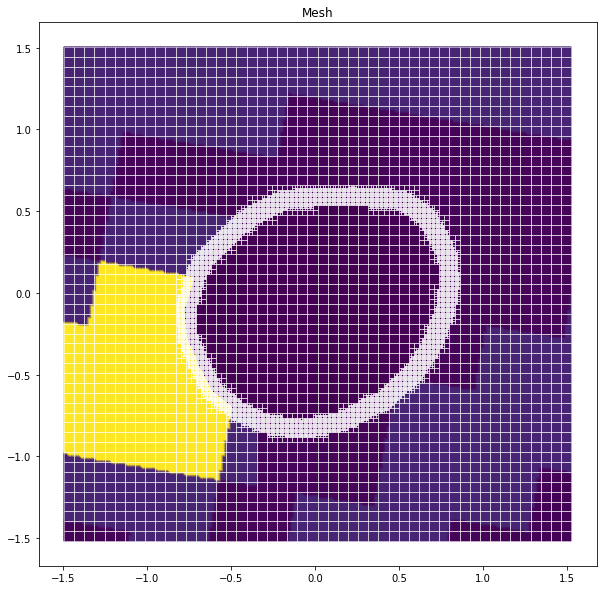

project > constrained 12068/12068 dofs


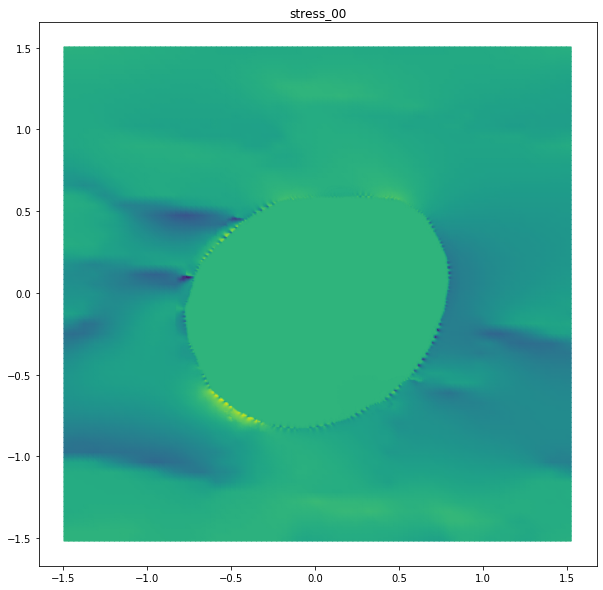

project > constrained 12068/12068 dofs


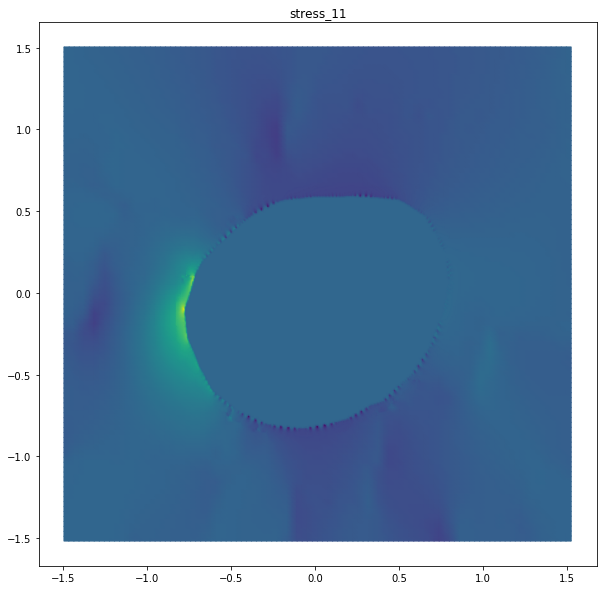

project > constrained 12068/12068 dofs


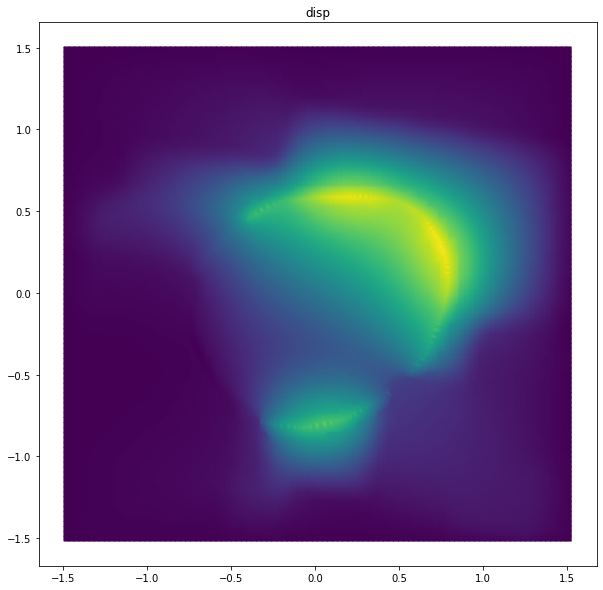

project > constrained 12068/12068 dofs
project > constrained 12068/12068 dofs
project > constrained 12068/12068 dofs


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

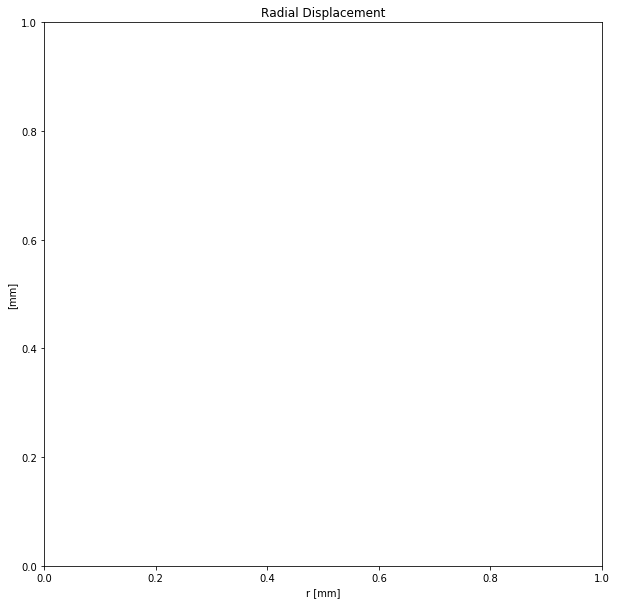

In [6]:
# Blood Mat Props
E_b = 1
nu_b = 0.0

# Artery Mat Props
E_a = 100
nu_a = 0.3

# Background Mesh
Nx = 50
Ny = 50
Lf = 1

# Basis
p = 2

# Quadrature Rules
q = 3
qu = 10

# Refinement Schemes
nref = 3
nqref = 3
delta = 0.05

# Export
figs = {"disp" : "Radial Displacement", "sigmaxx" : "sigmaxx", "sigmayy" : "sigmayy"}
plots = {"disp" : ["disp_smooth"], "sigmaxx" : ["stress_00_smooth"], "sigmatt" : ["stress_11_smooth"]}
xlabels = {"disp" : "r [mm]", "sigmaxx" : "r [mm]", "sigmayy" : "r [mm]"}
ylabels = {"disp" : "[mm]", "sigmarr" : "[MPa]", "sigmatt" : "[MPa]"}
vals2d = ["stress_00_smooth", "stress_11_smooth", "disp_smooth"]
vals1d = {"stress_00_smooth" : "$\sigma_{xx} smoothed$", "stress_11_smooth" : "$\sigma_{yy} smoothed$", "disp_smooth" : "u smoothed"}


results = ImmersedArtery(E_b, nu_b, E_a, nu_a, Nx, Ny, Lf, p, q, qu, nref, nqref, vals1d, vals2d, delta=delta)
Plot(figs, plots, xlabels, ylabels, results, {}, vals1d)

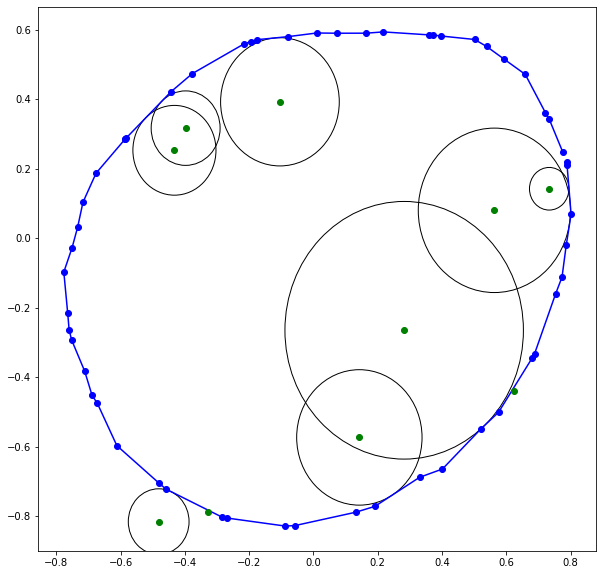

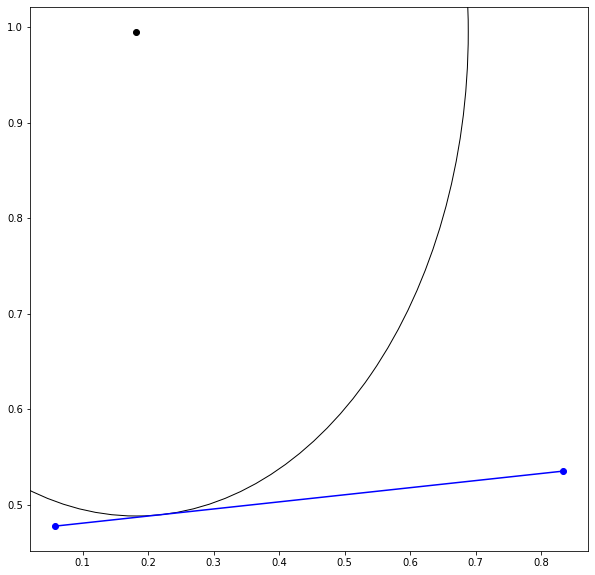

In [69]:
A = np.random.rand(2)
B = np.random.rand(2)
C = np.random.rand(2)

fig = plt.figure(figsize=(10,10))
axes = fig.add_subplot(1,1,1)

axes.plot([A[0], B[0]],[A[1],B[1]],'b-o')
axes.plot(C[0], C[1], 'ko')
d = DistancePointToLine(A[0], A[1], B[0], B[1], C[0], C[1])
circle = plt.Circle((C[0], C[1]), d, fill=False)
axes.add_artist(circle)


In [11]:
# Polygon Closest Point
class PolygonClosestPoint(function.Pointwise):
    @staticmethod
    def evalf(x,y, delta):
        shape = x.shape
        if shape == ():
            return x
        else:
            verts = sorted_pts.copy()
            vals = np.zeros(shape)
            for k in range(shape[0]):
                d = DistancePointToPolygon(verts, [x[k], y[k]])
                if d < delta:
                    d = 0.0
                vals[k] = d
            return vals
    
    def square(x):
        return x * x

    def distance_squared(vx, vy, wx, wy):
        return square(vx - wx) + square(vy - wy)

    def DistancePointToLine(vx, vy, wx, wy, px, py):
        d2 =  distance_squared(vx, vy, wx, wy) 
        if d2 == 0: 
            return np.sqrt(distance_squared(px, py, vx, vy))

        t = ((px - vx) * (wx - vx) + (py - vy) * (wy - vy)) / d2;

        if t < 0:
            return np.sqrt(distance_squared(px, py, vx, vy))
        elif t > 1.0:
            return np.sqrt(distance_squared(px, py, wx, wy))
        else:
            projx = vx + t * (wx - vx) 
            projy = vy + t * (wy - vy)
            return np.sqrt(distance_squared(px, py, projx, projy))

    def DistancePointToPolygon(verts, pt):
        A = verts[0]
        dmin = np.linalg.norm(A - pt)
        for i in range(1,len(verts)+1):
            B = verts[i % len(verts)]
            d = DistancePointToLine(A[0],A[1],B[0],B[1],pt[0],pt[1])
            if d < dmin:
                dmin = d
            A = B
        return dmin
    
    def _derivative(self, var, seen):
        return np.zeros(self.shape + var.shape)
    

    
class PolygonInteriorIndicator(function.Pointwise):
    @staticmethod
    def evalf(x,y, val_in, val_out):
        shape = x.shape
        if shape == ():
            return x
        else:
            vals = np.zeros(shape)
            for j in range(shape[0]):
                pt = [x[j] , y[j]]
                nIntersections = 0
                p1 = sorted_pts[0]
                for i in range(1,len(sorted_pts)+1):
                    p2 = sorted_pts[i % len(sorted_pts)]
                    if pt[1] > min([p1[1],p2[1]]):
                        if pt[1] <= max([p1[1],p2[1]]):
                            if pt[0] <= max([p1[0],p2[0]]):
                                if p1[1] != p2[1]:
                                    xint = (pt[1] - p1[1]) * (p2[0] - p1[0]) / (p2[1] - p1[1]) + p1[0]
                                    if p1[0] == p2[0] or pt[0] <= xint:
                                        nIntersections+=1
                    p1 = p2
                if nIntersections % 2 == 0:
                    vals[j] = val_out
                else:
                    vals[j] = val_in
            return vals 
                    
    def _derivative(self, var, seen):
        return np.zeros(self.shape + var.shape)

    
# Define Interior Function
# class PolygonInteriorIndicator(function.Pointwise):
#     @staticmethod
#     def evalf(x,y, val_in, val_out):
#         shape = x.shape
#         if shape == ():
#             return x
#         else:
#             vals = np.zeros(shape)
#             verts = sorted_pts.copy()
#             for j in range(shape[0]):
#                 pt = [x[j] , y[j]]
#                 if IsInsidePolygon(verts, pt):
#                     vals[j] = val_out
#                 else:
#                     vals[j] = val_in
#             return vals 
        
#     def IsInsidePolygon(verts, pt):
#         nIntersections = 0
#         p1 = verts[0]
#         for i in range(1,len(verts)+1):
#             p2 = verts[i % len(verts)]
#             if pt[1] > min([p1[1],p2[1]]):
#                 if pt[1] <= max([p1[1],p2[1]]):
#                     if pt[0] <= max([p1[0],p2[0]]):
#                         if p1[1] != p2[1]:
#                             xint = (pt[1] - p1[1]) * (p2[0] - p1[0]) / (p2[1] - p1[1]) + p1[0]
#                             if p1[0] == p2[0] or pt[0] <= xint:
#                                 nIntersections+=1
#             p1 = p2
#         if nIntersections % 2 == 0:
#             return False
#         else:
#             return True
    
#     def _derivative(self, var, seen):
#         return np.zeros(self.shape + var.shape)

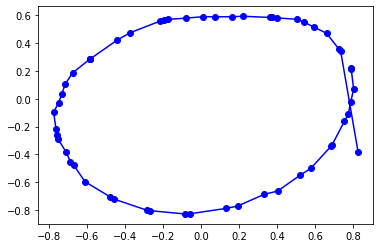

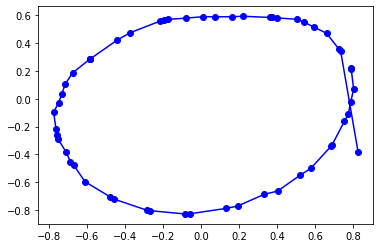

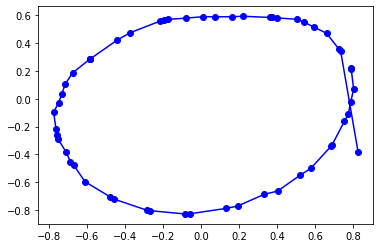

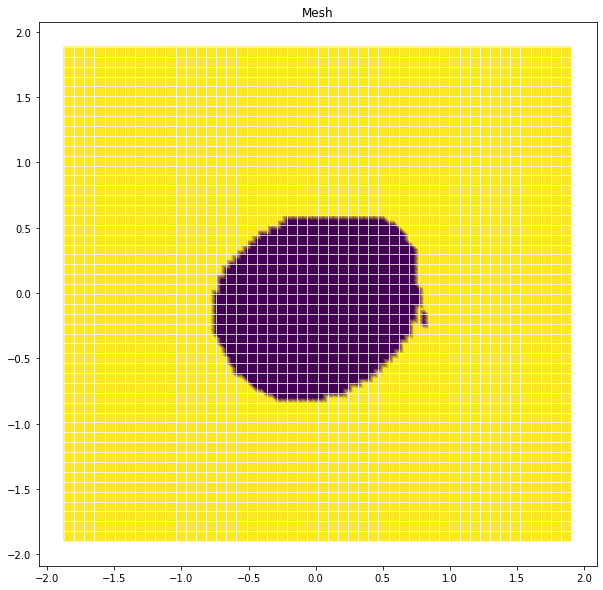

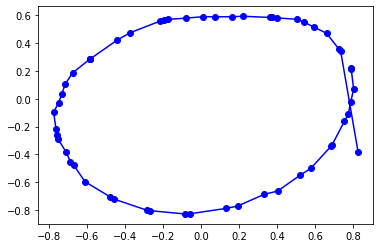

EvaluationError: 
  %0 = EVALARGS
  %1 = Constant()()
  %2 = Constant()()
  %3 = Constant()()
  %4 = Tuple()
  %5 = Constant()()
  %6 = Constant()()
  %7 = Constant()()
  %8 = SelectChain(evalargs=%0)
  %9 = Points(evalargs=%0)
  %10 = PopHead(trans=%8)
  %11 = ApplyTransforms(2)(points=%9, chain=%10)
  %12 = Get()(arr=%11, item=%6)
  %13 = Get()(arr=%11, item=%3)
  %14 = Einsum()(arr1=%12, arr2=%2)
  %15 = Einsum()(arr1=%13, arr2=%2)
  %16 = Add()(arr1=%14, arr2=%5)
  %17 = Add()(arr1=%15, arr2=%7)
  %18 = PolygonClosestPoint()(x=%16, y=%17, delta=%1) --> NameError: name 'DistancePointToPolygon' is not defined

In [14]:
N = 50
Lf = 1

# background mesh
ns = function.Namespace()
centroid = PolygonCentroid(sorted_pts)
radius = EffectivePolygonDiameter(sorted_pts)
x = np.linspace(centroid[0] - Lf * radius, centroid[0] + Lf * radius, N+1)
y = np.linspace(centroid[1] - Lf * radius, centroid[1] + Lf * radius, N+1)
topo, ns.x = mesh.rectilinear([x,y])

n = 3
delta = 0.0
plt.plot(sorted_pts[:,0], sorted_pts[:,1] , '-bo')
plt.show()
ns.closestpt = PolygonClosestPoint(ns.x[0], ns.x[1], delta)
plt.plot(sorted_pts[:,0], sorted_pts[:,1] , '-bo')
plt.show()
ns.isInside = PolygonInteriorIndicator(ns.x[0], ns.x[1], -1, 1)
plt.plot(sorted_pts[:,0], sorted_pts[:,1] , '-bo')
plt.show()
ns.sdf = 'closestpt isInside'
nref = 2


#rtopo = RefineBySDF(topo, ns.sdf, nref)

PlotMesh(topo, ns.x, ns.isInside, n=n)
plt.plot(sorted_pts[:,0], sorted_pts[:,1] , '-bo')
plt.show()
PlotMesh(topo, ns.x, ns.closestpt, n=n)
plt.plot(sorted_pts[:,0], sorted_pts[:,1] , '-bo')
plt.show()
PlotMesh(topo, ns.x, ns.sdf, n=n)
plt.plot(sorted_pts[:,0], sorted_pts[:,1] , '-bo')
plt.show()

In [14]:
def Remap(val, a1, b1, a2, b2):
    return a2 + (val - a1) / (b1 - a1) * (b2 - a2)

def square(x):
    return x * x

def distance_squared(vx, vy, wx, wy):
    return square(vx - wx) + square(vy - wy)

def DistancePointToLine(vx, vy, wx, wy, px, py):
    d2 =  distance_squared(vx, vy, wx, wy) 
    if d2 == 0: 
        return np.sqrt(distance_squared(px, py, vx, vy))
    
    t = ((px - vx) * (wx - vx) + (py - vy) * (wy - vy)) / d2;
    
    if t < 0:
        return np.sqrt(distance_squared(px, py, vx, vy))
    elif t > 1.0:
        return np.sqrt(distance_squared(px, py, wx, wy))
    else:
        projx = vx + t * (wx - vx) 
        projy = vy + t * (wy - vy)
        return np.sqrt(distance_squared(px, py, projx, projy))

def DistancePointToPolygon(verts, pt):
    A = verts[0]
    dmin = np.linalg.norm(A - pt)
    for i in range(1,len(verts)+1):
        B = verts[i % len(verts)]
        d = DistancePointToLine(A[0],A[1],B[0],B[1],pt[0],pt[1])
        if d < dmin:
            dmin = d
        A = B
    return dmin

def IsInsidePolygon(verts, pt):
    nIntersections = 0
    p1 = verts[0]
    for i in range(1,len(verts)+1):
        p2 = verts[i % len(verts)]
        if pt[1] > min([p1[1],p2[1]]):
            if pt[1] <= max([p1[1],p2[1]]):
                if pt[0] <= max([p1[0],p2[0]]):
                    if p1[1] != p2[1]:
                        xint = (pt[1] - p1[1]) * (p2[0] - p1[0]) / (p2[1] - p1[1]) + p1[0]
                        if p1[0] == p2[0] or pt[0] <= xint:
                            nIntersections+=1
        p1 = p2
    if nIntersections % 2 == 0:
        return False
    else:
        return True
    
def GetBounds(verts, h):
    ax = min(verts[:,0]) - h
    bx = max(verts[:,0]) + h
    ay = min(verts[:,1]) - h
    by = max(verts[:,1]) + h
    return ax, bx, ay, by

def TestIsInsidePolygon(verts, N, h):
    fig = plt.figure(figsize=(10,10))
    axes = fig.add_subplot(1,1,1)
    axes.plot(verts[:,0], verts[:,1], '-bo')
    axes.plot([verts[-1,0], verts[0,0]],[verts[-1,1],verts[0,1]],'-bo')
    ax, bx, ay, by = GetBounds(verts, h)
    for i in range(N):
        r1 = np.random.rand()
        r2 = np.random.rand()
        pt = [Remap(r1, 0, 1, ax, bx), Remap(r2, 0, 1, ay, by)]
        if(IsInsidePolygon(sorted_pts, pt)):
            axes.plot(pt[0],pt[1], 'go')
        else:
            axes.plot(pt[0],pt[1], 'ro')
            
def TestPolygonClosestPoint(verts, N, h):
    fig = plt.figure(figsize=(10,10))
    axes = fig.add_subplot(1,1,1)
    axes.plot(verts[:,0], verts[:,1], '-bo')
    axes.plot([verts[-1,0], verts[0,0]],[verts[-1,1],verts[0,1]],'-bo')
    ax, bx, ay, by = GetBounds(verts, h)
    for i in range(N):
        r1 = np.random.rand()
        r2 = np.random.rand()
        pt = [Remap(r1, 0, 1, ax, bx), Remap(r2, 0, 1, ay, by)]
        axes.plot(pt[0],pt[1], 'go')
        d = DistancePointToPolygon(sorted_pts, pt)
        circle = plt.Circle((pt[0], pt[1]), d, fill=False)
        axes.add_artist(circle)

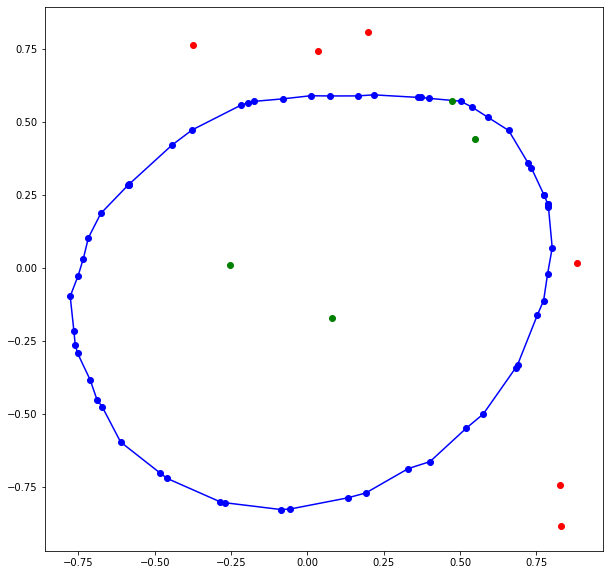

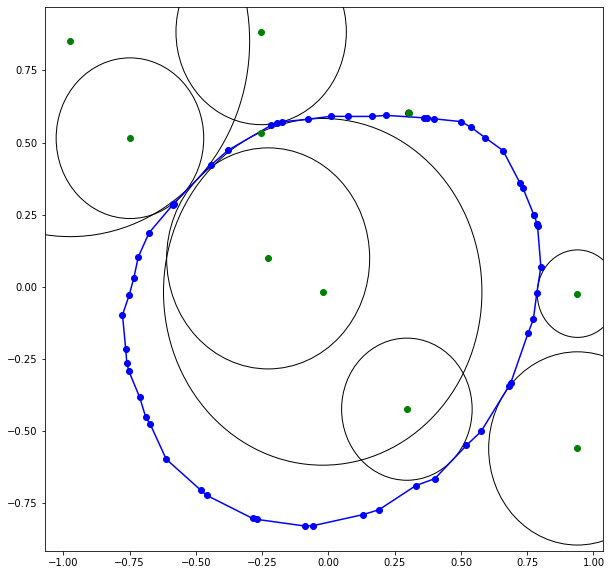

In [20]:
N = 10
h = 0.3

TestIsInsidePolygon(sorted_pts, N, h)
TestPolygonClosestPoint(sorted_pts, N, h)





In [16]:
def ReadMetaImage(fname):
    rd = vtk.vtkMetaImageReader()
    rd.SetFileName(fname)
    rd.Update()
    img = rd.GetOutput()
    return img

def GetPolyDataConnectivity(polydata):
    cells = polydata.GetPolys()
    conn = numpy_support.vtk_to_numpy( cells.GetConnectivityArray() )
    return conn

def GetImageOrigin(image):
    return np.array(image.GetOrigin())

def GetImageSpacing(image):
    return np.array(image.GetSpacing())

def GetImageShape(image):
    return np.array(image.GetDimensions())

class MaterialProperties(function.Pointwise):
    
    @staticmethod
    def evalf(x,y):
        
        def GetMaterial(label):
            if label == -1:
                return 1
            if label == 75:
                return 3
            if label == 225:
                return 4
            if label == 33:
                return 2
            else:
                return 0
        
        def IsInsidePolygon(verts, pt):
            nIntersections = 0
            p1 = verts[0]
            for i in range(1,len(verts)+1):
                p2 = verts[i % len(verts)]
                if pt[1] > min([p1[1],p2[1]]):
                    if pt[1] <= max([p1[1],p2[1]]):
                        if pt[0] <= max([p1[0],p2[0]]):
                            if p1[1] != p2[1]:
                                xint = (pt[1] - p1[1]) * (p2[0] - p1[0]) / (p2[1] - p1[1]) + p1[0]
                                if p1[0] == p2[0] or pt[0] <= xint:
                                    nIntersections+=1
                p1 = p2
            if nIntersections % 2 == 0:
                return False
            else:
                return True
        
        def InverseTransformPoint(pt, M, origin):
            mapped_pt = pt[0] * M[0] + pt[1] * M[1] + origin 
            return mapped_pt

        def PointToVoxelCoordinates(pt, origin, spacing):
            x = np.floor( (pt + spacing / 2 - origin) / spacing )
            return x.astype(int)

        def VoxelCoordinatesToID(coords, shape):
            return coords[0] + coords[1] * shape[0] + coords[2] * shape[0] * shape[1]
        
        def EvaluateMetaImage(pt, image_origin, image_spacing, image_shape, data):
            coords = PointToVoxelCoordinates(pt, image_origin, image_spacing)
            voxelID = VoxelCoordinatesToID(coords, image_shape)
            return data[voxelID]
        
        def ShapeFunction0(xi):
            return 1.0 - xi
        
        def ShapeFunction1(xi):
            return xi
        
        def InterpolateCube(xi, coefs):
            val = 0.0
            f = [ShapeFunction0, ShapeFunction1]
            for i in range(2):
                for j in range(2):
                    for k in range(2):
                        val += coefs[i,j,k] * f[i](xi[0]) * f[j](xi[1]) * f[k](xi[2])
            return val            
        
        def GetVoxelPosition(coords, origin, spacing):
            return origin + spacing * coords
        
        def MapPointToLocal(pt, coords, image_origin, image_spacing):
            pos = GetVoxelPosition(coords, image_origin, image_spacing)
            xi = (pt - pos) / (image_spacing / 2)
            return xi
        
        def GetInterpolationCoords(pt, image_origin, image_spacing):
            coords = PointToVoxelCoordinates(pt, image_origin, image_spacing)
            xi = MapPointToLocal(pt, coords, image_origin, image_spacing)
            for i in range(len(xi)):
                if xi[i] < 0:
                    coords[i] -= 1
            return coords

        def InterpolateMetaImage(pt, image_origin, image_spacing, image_shape, data):
            coords = GetInterpolationCoords(pt, image_origin, image_spacing)
            xi = MapPointToLocal(pt, coords, image_origin, image_spacing) / 2
            coefs = np.zeros([2,2,2])
            for i in range(2):
                for j in range(2):
                    for k in range(2):
                        vcoords = [coords[0] + i, coords[1] + j, coords[2] + k]
                        vID =  VoxelCoordinatesToID(vcoords, image_shape)
                        coefs[i,j,k] = data[vID]
            return InterpolateCube(xi, coefs)
        
        shape = x.shape
        if shape == ():
            return x
        else:
            vals = np.zeros(shape)
            for s in range(shape[0]):
                pt = [x[s], y[s]]
                isBlood = IsInsidePolygon(sorted_pts, pt)
                if isBlood:
                    label = -1
                else:
                    mapped_pt = InverseTransformPoint(pt, M, sampling_plane_origin)
                    wall_sdf_val = InterpolateMetaImage(mapped_pt, wall_sdf_image_origin, wall_sdf_image_spacing, wall_sdf_image_shape, wall_sdf_image_vals)
                    autoplaque_val = EvaluateMetaImage(mapped_pt, autoplaque_image_origin, autoplaque_image_spacing, autoplaque_image_shape, autoplaque_image_labels)
                    if autoplaque_val == 0 and wall_sdf_val < 0:
                        label = 33
                    else:
                        label = autoplaque_val
                val = GetMaterial(label)
                vals[s] = val
            return vals
    
    def _derivative(self, var, seen):
        return np.zeros(self.shape + var.shape)

In [17]:
autoplaque_image = ReadMetaImage("data/autoplaque.mha")
autoplaque_image_slice = SliceMesh(autoplaque_image,sampling_plane)
autoplaque_image_slice_pts = GetMeshPoints(autoplaque_image_slice)
autoplaque_image_slice_labels = GetMeshData(autoplaque_image_slice, "MetaImage")
autoplaque_image_slice_cells = GetPolyDataConnectivity(autoplaque_image_slice)
autoplaque_image_labels = GetMeshData(autoplaque_image, "MetaImage")

In [18]:
autoplaque_image_origin = GetImageOrigin(autoplaque_image)
autoplaque_image_spacing = GetImageSpacing(autoplaque_image)
autoplaque_image_shape = GetImageShape(autoplaque_image)

In [19]:
wall_sdf_image = ReadMetaImage("data/outer_wall.mha")
wall_sdf_image_slice = SliceMesh(wall_sdf_image,sampling_plane)
wall_sdf_image_slice_pts = GetMeshPoints(wall_sdf_image_slice)
wall_sdf_image_slice_labels = GetMeshData(wall_sdf_image_slice, "MetaImage")
wall_sdf_image_slice_cells = GetPolyDataConnectivity(wall_sdf_image_slice)
wall_sdf_image_vals = GetMeshData(wall_sdf_image, "MetaImage")

In [20]:
wall_sdf_image_origin = GetImageOrigin(wall_sdf_image)
wall_sdf_image_spacing = GetImageSpacing(wall_sdf_image)
wall_sdf_image_shape = GetImageShape(wall_sdf_image)

In [21]:
N = 50
Lf = 3

# background mesh
ns = function.Namespace()
centroid = PolygonCentroid(sorted_pts)
radius = EffectivePolygonDiameter(sorted_pts)
x = np.linspace(centroid[0] - Lf * radius, centroid[0] + Lf * radius, N+1)
y = np.linspace(centroid[1] - Lf * radius, centroid[1] + Lf * radius, N+1)
topo, ns.x = mesh.rectilinear([x,y])

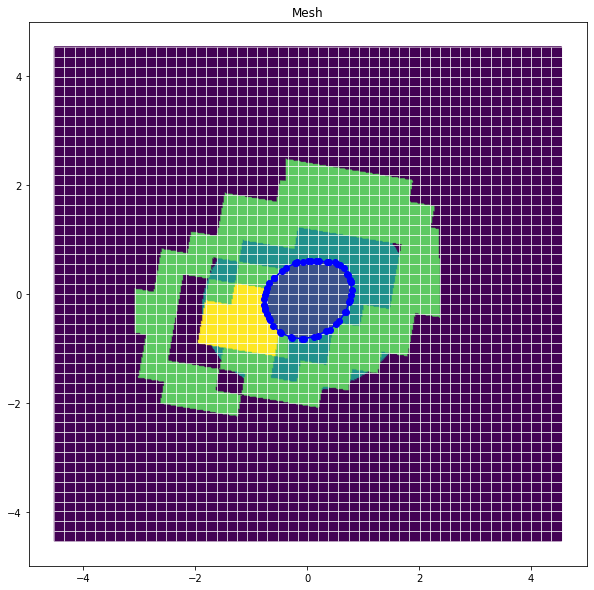

In [27]:
n = 10
arrow_size = 0.0001

ns.autoplaque = MaterialProperties(ns.x[0], ns.x[1])
bez = topo.sample('bezier', n)
ax = PlotMesh(topo, ns.x, ns.autoplaque, n=n)
ax.plot(sorted_pts[:,0], sorted_pts[:,1], '-bo')
ax.plot([sorted_pts[-1,0], sorted_pts[0,0]],[sorted_pts[-1,1],sorted_pts[0,1]],'-bo')
for i in range(len(sorted_tractions)):
    v = arrow_size * sorted_tractions[i]
    a = sorted_pts[i]
    # ax.arrow(a[0], a[1], v[0], v[1], color='r')

project > constrained 2704/2704 dofs


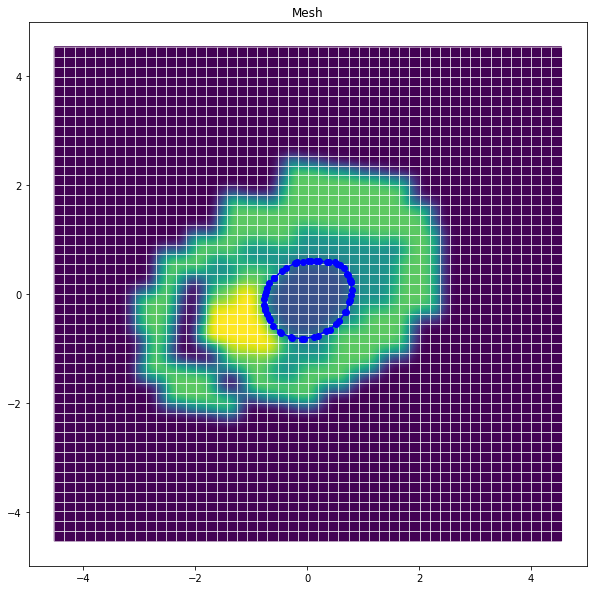

In [25]:
n = 10
arrow_size = 0.0001

ns.autoplaque = MaterialProperties(ns.x[0], ns.x[1])
pproj = 2
ns.basisproj = topo.basis('spline',pproj)
ns.autoplaqueproj = topo.projection(ns.autoplaque, onto=ns.basisproj, geometry=ns.x, ptype='convolute', ischeme='gauss{}'.format(2*pproj))
bez = topo.sample('bezier', n)
ax = PlotMesh(topo, ns.x, ns.autoplaqueproj, n=n)
ax.plot(sorted_pts[:,0], sorted_pts[:,1], '-bo')
ax.plot([sorted_pts[-1,0], sorted_pts[0,0]],[sorted_pts[-1,1],sorted_pts[0,1]],'-bo')
for i in range(len(sorted_tractions)):
    v = arrow_size * sorted_tractions[i]
    a = sorted_pts[i]
    # ax.arrow(a[0], a[1], v[0], v[1], color='r')

project > constrained 2601/2601 dofs


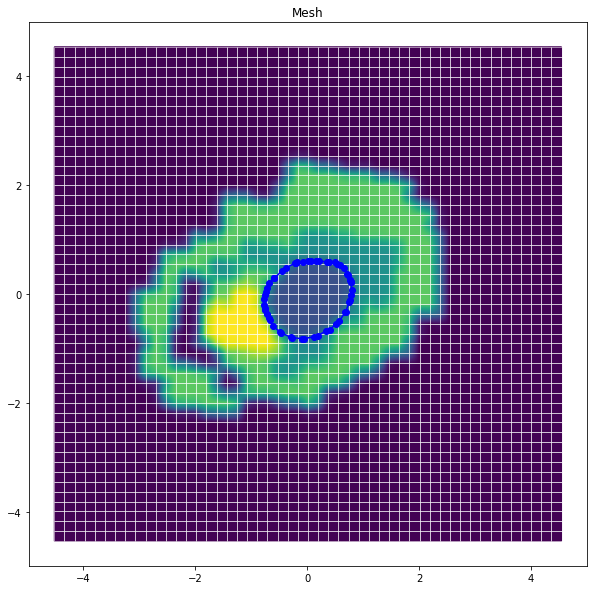

In [26]:
n = 10
arrow_size = 0.0001

ns.autoplaque = MaterialProperties(ns.x[0], ns.x[1])
pproj = 1
ns.basisproj = topo.basis('spline',pproj)
ns.autoplaqueproj = topo.projection(ns.autoplaque, onto=ns.basisproj, geometry=ns.x, ptype='convolute', ischeme='gauss{}'.format(2*pproj))
bez = topo.sample('bezier', n)
ax = PlotMesh(topo, ns.x, ns.autoplaqueproj, n=n)
ax.plot(sorted_pts[:,0], sorted_pts[:,1], '-bo')
ax.plot([sorted_pts[-1,0], sorted_pts[0,0]],[sorted_pts[-1,1],sorted_pts[0,1]],'-bo')
for i in range(len(sorted_tractions)):
    v = arrow_size * sorted_tractions[i]
    a = sorted_pts[i]
    # ax.arrow(a[0], a[1], v[0], v[1], color='r')

2

In [154]:
def PointToVoxelCoordinates(pt, origin, spacing):
    x = np.floor( (pt + spacing / 2 - origin) / spacing )
    return x.astype(int)

def VoxelCoordinatesToID(coords, shape):
    return coords[0] + coords[1] * shape[0] + coords[2] * shape[0] * shape[1]

def ShapeFunction0(xi):
    return 1.0 - xi

def ShapeFunction1(xi):
    return xi

def InterpolateCube(xi, coefs):
    val = 0.0
    f = [ShapeFunction0, ShapeFunction1]
    for i in range(2):
        for j in range(2):
            for k in range(2):
                val += coefs[i,j,k] * f[i](xi[0]) * f[j](xi[1]) * f[k](xi[2])
    return val            

def GetVoxelPosition(coords, origin, spacing):
    return origin + spacing * coords

def GetInterpolationCoords(pt, image_origin, image_spacing, image_shape):
    coords = PointToVoxelCoordinates(pt, image_origin, image_spacing)
    pos = GetVoxelPosition(coords, image_origin, image_spacing)
    xi = (pt - pos) / image_spacing
    for i in range(len(xi)):
        if xi[i] < 0.5:
            coords[i] -= 1
    return coords
        
def InterpolateMetaImage(pt, image_origin, image_spacing, image_shape, data):
    coords = GetInterpolationCoords(pt, image_origin, image_spacing, image_shape)
    coefs = np.zeros([2,2,2])
    for i in range(2):
        for j in range(2):
            for k in range(2):
                vcoords = [coords[0] + i, coords[1] + j, coords[2] + k]
                vID =  VoxelCoordinatesToID(vcoords, image_shape)
                coefs[i,j,k] = data[vID]
    return InterpolateCube(xi, coefs)

def InverseTransformPoint(pt, M, origin):
    mapped_pt = pt[0] * M[0] + pt[1] * M[1] + origin 
    return mapped_pt

In [117]:
pt = np.random.rand(2)
mapped_pt = InverseTransformPoint(pt, M, sampling_plane_origin)
val = InterpolateMetaImage(mapped_pt, wall_sdf_image_origin, wall_sdf_image_spacing, wall_sdf_image_shape, wall_sdf_image_vals)
print(pt)
print(val)

(3,)
(3,)
(3,)


TypeError: only size-1 arrays can be converted to Python scalars

In [39]:
print(np.unique(wall_sdf_image_vals))

[-16.298208  -16.260138  -16.247124  ...   1.2990367   1.299037
   1.299038 ]


In [100]:
xi = [0.5, 0.5, 0.5]
coefs = np.zeros([2,2,2])
coefs[0,0,0] = 1.0
InterpolateCube(xi, coefs)

0.125

In [118]:
PointToVoxelCoordinates(mapped_pt, wall_sdf_image_origin, wall_sdf_image_spacing)

(3,)
(3,)
(3,)


TypeError: only size-1 arrays can be converted to Python scalars

In [121]:
x = np.floor( (mapped_pt + wall_sdf_image_spacing / 2 - wall_sdf_image_origin) / wall_sdf_image_spacing )
x = x.astype(int)

In [153]:
coords = np.array([272, 237, 357])
print( GetVoxelPosition(coords, wall_sdf_image_origin, wall_sdf_image_spacing) )
vID = VoxelCoordinatesToID(coords, wall_sdf_image_shape)
print(wall_sdf_image.GetPoint(vID))

[  35.25 -183.75  632.75]
(35.25, -183.75, 632.75)


In [146]:
pt = np.ndarray([3])
a = wall_sdf_image.GetPoint(0)
print(a)

(-32.75, -243.0, 543.5)


In [12]:
print(connectivity)

[[ 0  1]
 [ 1  2]
 [ 2  3]
 [ 3  4]
 [ 4  5]
 [ 5  6]
 [ 6  7]
 [ 7  8]
 [ 8  9]
 [ 9 10]
 [10 11]
 [11 12]
 [12 13]
 [13 14]
 [14 15]
 [15 16]
 [16 17]
 [17 18]
 [18 19]
 [19 20]
 [20 21]
 [21 22]
 [22 23]
 [23 24]
 [24 25]
 [25 26]
 [26 27]
 [27 28]
 [28 29]
 [29 30]
 [30 31]
 [31 32]
 [32 33]
 [33 34]
 [34 35]
 [35 36]
 [36 37]
 [37 38]
 [38 39]
 [39 40]
 [40 41]
 [41 42]
 [42 43]
 [43 44]
 [44 45]
 [45 46]
 [46 47]
 [47 48]
 [48 49]
 [49 50]
 [50 51]
 [51 52]
 [52 53]
 [53 54]
 [54  0]]
